In [1]:
%matplotlib inline 
%load_ext autoreload 
%autoreload 2

from __future__ import print_function, \
    division, \
    absolute_import

import os

import sep
import h5py

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

from astropy.io import fits
from astropy.modeling import models, fitting

#---------------------------------------------------------------------------#
#User imports
import sys
sys.path.append('/Users/fardila/Documents/Github/kungpao')
from kungpao.galsbp import galSBP
from kungpao.display import display_single, random_cmap

Created TAP+ (v1.0) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
# For Kungpao
x_images = '/Users/fardila/anaconda/envs/hsc_hydro/iraf/bin.macosx/x_images.e'
x_ttools = '/Users/fardila/anaconda/envs/hsc_hydro/iraf_extern/tables/bin.macosx/x_ttools.e'
x_isophote = '/Users/fardila/anaconda/envs/hsc_hydro/iraf_extern/stsdas/bin.macosx/x_isophote.e'
#---------------------------------------------------------------------------#

#---------------------------------------------------------------------------#
# About the Colormaps
IMG_CMAP = plt.get_cmap('viridis')
IMG_CMAP.set_bad(color='black')

SEG_CMAP = random_cmap(ncolors=512, background_color=u'white')
SEG_CMAP.set_bad(color='white')
SEG_CMAP.set_under(color='white')

In [3]:
from pyraf import iraf

iraf.tables()
iraf.stsdas()
iraf.analysis()
iraf.isophote()

iraf.unlearn('ellipse')
iraf.unlearn('bmodel')



      +------------------------------------------------------------+
      |             Space Telescope Tables Package                 |    
      |                  TABLES Version 3.17                       |
      |                                                            |
      |   Space Telescope Science Institute, Baltimore, Maryland   |
      |   Copyright (C) 2014 Association of Universities for       |
      |            Research in Astronomy, Inc.(AURA)               |
      |       See stsdas$copyright.stsdas for terms of use.        |
      |         For help, send e-mail to help@stsci.edu            |
      +------------------------------------------------------------+
tables/:
 fitsio/        tbplot/         tobsolete/      ttools/


      +------------------------------------------------------------+
      |       Space Telescope Science Data Analysis System         |    
      |                   STSDAS Version 3.17                      |
      |                   

In [4]:
#constants
h=0.704 #Illustris, comoving
#HSC: h=0.7, proper distances


In [5]:
def load_pkl(filename):
    try:
        import cPickle as pickle
    except:
        warnings.warn("## cPickle is not available!!")
        import pickle
    
    if os.path.isfile(filename):
        pklFile = open(filename, 'rb')
        data = pickle.load(pklFile)    
        pklFile.close()
    
        return data
    else: 
        warnings.warn("## Can not find %s, return None" % filename)
        return None
    
    
def save_to_fits(image, name):
    """
    Save a 2-D array as fits image.
    """
    hdu = fits.PrimaryHDU(image)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(name, overwrite=True)
    
    return


def show_illustris(img_cen, img_sat, img_icl, img_all):
    """
    Show the images of Illustris simulated galaxy.
    """
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                        top=1.0, right=1.0, 
                        left=0.0, bottom=0.0)

    ax1 = plt.subplot(2, 2, 1)
    ax1 = display_single(img_all, ax=ax1, 
                         contrast=0.15,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)

    ax2 = plt.subplot(2, 2, 2)
    ax2 = display_single(img_cen, ax=ax2, 
                         contrast=0.10,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)

    ax3 = plt.subplot(2, 2, 3)
    ax3 = display_single(img_sat, ax=ax3, 
                         contrast=0.12,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)

    ax4 = plt.subplot(2, 2, 4)
    ax4 = display_single(img_icl, ax=ax4, 
                         contrast=0.01,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)
    
    return fig

# Illustris stellar mass maps

In [18]:
illustris_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/galaxies_star_maps.hdf5'

# 10 galaxies, 3 maps (galaxy, surrounding, diffuse), 
#  3 projections (xy, xz, yz), 200 x 200 images
#  1 pixel = 3 kpc

#map_stars.shape

#scale factor
f = h5py.File(illustris_file, 'r')
print(f.keys())
print(f.attrs.keys())
snap_a = f.attrs['snap_a']
map_size = np.array(f['map_stars_size'])
n_pixels = np.array(f['map_stars_npixel'])
f.close()

print(snap_a)
print(map_size, n_pixels)

pixel_scale = 3.0 # kpc / pixel


[u'cat_grp_id', u'cat_grp_is_primary', u'cat_grp_m200c', u'cat_grp_n', u'cat_sh_bh_mdot', u'cat_sh_halfmrad_gas', u'cat_sh_halfmrad_stars', u'cat_sh_id', u'cat_sh_mbh', u'cat_sh_mdm', u'cat_sh_metallicity', u'cat_sh_mgas', u'cat_sh_mstar', u'cat_sh_phot_B', u'cat_sh_phot_K', u'cat_sh_phot_U', u'cat_sh_phot_V', u'cat_sh_phot_g', u'cat_sh_phot_i', u'cat_sh_phot_r', u'cat_sh_phot_z', u'cat_sh_pos_bound', u'cat_sh_pos_cm', u'cat_sh_sfr', u'cat_sh_spin', u'cat_sh_vel', u'cat_sh_vmax', u'map_stars', u'map_stars_npixel', u'map_stars_nptl', u'map_stars_size']
[u'sim', u'snap_idx', u'snap_a']
1.0
300.0 200


# Automate stages 1, 2, 3

In [8]:
def fit_isophotes(image, iso, iso_bin, prefix, suffix, stage):
    # Here, we use the stsdas.isophote.analysis.bmodel function to reconstruct 
    # a 2-D model using the isophote information 
    # So that we can subtract it from the original image, and see how well it does.
    try: 
        os.remove(prefix + suffix + '_ellip_' + str(stage) + '.fits')
    except Exception: 
        pass

    iraf.bmodel(parent=prefix + suffix + '.fits', 
                table=iso_bin,
                output=prefix + suffix + '_ellip_' + str(stage) + '.fits',
                minsma=0.0,
                highar='no')

    img_ellip = fits.open(prefix + suffix + '_ellip_'+str(stage)+'.fits')[0].data

    fig = plt.figure(figsize=(8, 8))
    fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                        left=0.0, bottom=0.0,
                        top=1.0, right=1.0)
    ax1 = fig.add_subplot(1, 1, 1)

    ax1 = display_single(image - img_ellip, 
                         ax=ax1,
                         contrast=0.15,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='linear',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)

    # Overplot a subsample of isophotes on the image
    iso_ellip = galSBP.convIso2Ell(iso)
    for ii, e in enumerate(iso_ellip):
        if (ii % 3 == 0):
            ax1.add_artist(e)
            e.set_clip_box(ax1.bbox)
            e.set_alpha(0.6)
            e.set_edgecolor('r')
            e.set_facecolor('none')
            e.set_linewidth(2.0)
    
    return iso_ellip


def check_profile(iso):
    # Normally it is better to also check the profiles for geometry 
    fig = plt.figure(figsize=(8, 7))
    fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                        left=0.13, bottom=0.10,
                        top=0.97, right=0.97)

    ax1 = plt.subplot(4, 1, 1)
    ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)
    ax1.plot(iso['sma'], iso['x0'], linewidth=3.0)
    ax1.set_ylabel(r'$\mathrm{X}_0$', fontsize=20)

    ax2 = plt.subplot(4, 1, 2)
    ax2.grid(linewidth=2.0, linestyle='--', alpha=0.5)
    ax2.plot(iso['sma'], iso['y0'], linewidth=3.0)
    ax2.set_ylabel(r'$\mathrm{Y}_0$', fontsize=20)

    ax3 = plt.subplot(4, 1, 3)
    ax3.grid(linewidth=2.0, linestyle='--', alpha=0.5)
    ax3.plot(iso['sma'], iso['ell'], linewidth=3.0)
    ax3.set_ylabel(r'$e$', fontsize=20)

    ax4 = plt.subplot(4, 1, 4)
    ax4.grid(linewidth=2.0, linestyle='--', alpha=0.5)
    ax4.plot(iso['sma'], iso['pa'], linewidth=3.0)
    ax4.set_ylabel(r'$\mathrm{PA}$', fontsize=20)
    ax4.set_xlabel(r'$\mathrm{SMA}$', fontsize=25)

In [9]:
def fit_profile(sim_file, pixel_scale, gal_n=0, cen=True, sat=False, icl=False, plots=True):
    
    # Load general simulation and galaxy properties
    f = h5py.File(sim_file, 'r')
    snap_a = f.attrs['snap_a']
    n_galaxies = len(f['cat_sh_id'])
    sh_idx = np.array(f['cat_sh_id'])
    grp_idx = np.array(f['cat_grp_id'])
    cat_is_primary = np.array(f['cat_grp_is_primary'])
    cat_sh_mstar = np.array(f['cat_sh_mstar'])
    cat_sh_pos_bound = np.array(f['cat_sh_pos_bound'])
    cat_sh_halfmrad_stars = np.array(f['cat_sh_halfmrad_stars'])

    map_stars = np.array(f['map_stars'])
    map_size = f['map_stars_size'].value
    n_pixels = f['map_stars_npixel'].value
    f.close()
    
    #make maps
    img_cen = map_stars[gal_n, 0, 1] * (pixel_scale ** 2) # Central 
    img_sat = map_stars[gal_n, 1, 1] * (pixel_scale ** 2) # Satellites
    img_icl = map_stars[gal_n, 2, 1] * (pixel_scale ** 2) # Diffuse
    img_cen_sat = (img_cen + img_sat)           # Central + Satellites
    img_cen_icl = (img_cen + img_icl)           # Central + Satellites
    img_all = (img_cen + img_sat + img_icl)           # Central + Satellites + Diffuse
    
    #convert the image into unit of stellar mass instead of mass density
    log_mstar = np.log10(cat_sh_mstar[0])
    log_mcen = np.log10(np.sum(img_cen))
    
    #ouput maps
    maps_location='/Users/fardila/Documents/GitHub/HSC_vs_hydro/notebooks/felipe_test/maps/'
    fits_prefix = maps_location+'illustris_1_xy'
    save_to_fits(img_cen, fits_prefix + '_cen.fits')
    save_to_fits(img_cen_sat, fits_prefix + '_cen_sat.fits')
    save_to_fits(img_cen_icl, fits_prefix + '_cen_icl.fits')
    save_to_fits(img_all, fits_prefix + '_all.fits')
    
    #determine which map to use
    if cen:
        if sat:
            if icl:
                image=img_all
                print('Central+Satellites+ICL')
                suffix='_all'
            else: 
                image=img_cen_sat
                print('Central+Satellites')
                suffix='_cen_sat'
        elif icl:
            image=img_cen_icl
            print('Central+ICL')
            suffix='_cen_icl'
        else:
            image=img_cen
            print('Central only')
            suffix='_cen'
    else:
        raise ValueError('Are you sure you don\'t want to use the central???')
    
    # Measure the background,
    # Here on the image has no noise and has a lot of diffuse features
    # so measure sky using a very small box (bw, bh values) helps us remove 
    # a lot of the them, make the detection easier
    # See: http://sep.readthedocs.io/en/v1.0.x/api/sep.Background.html#sep.Background 
    # For more details
    bkg = sep.Background(image, bw=10, bh=10, fw=5, fh=5)
    print("# Mean Sky / RMS Sky = %10.5f / %10.5f" % (bkg.globalback, bkg.globalrms))

    
    # Object detection after subtracting the background
    # Since there is no noise on the image, we will just use the global RMS 
    # from the background estimate as error
    # Here, we use very high threshold, less aggressive deblending method to 
    # make the detection focuses on the big object
    objs, seg = sep.extract(image - bkg.back(), 
                                    20.0,
                                    err=bkg.globalrms,
                                    minarea=1000,
                                    deblend_nthresh=24, 
                                    deblend_cont=0.1,
                                    segmentation_map=True)
    
    # And this is how you turn the segmentation image into a mask
    # You can remove certain object from the segmentation map first
    seg_mask = (seg > 0)
    print("# Detect %d objects" % len(objs))

    #################################################################################################
    #stage 1: Free center and geometry
    #################################################################################################
    print('****************STAGE 1****************')
    stage = 1
    iso_1, iso_1_bin = galSBP.galSBP(maps_location+'illustris_1_xy'+suffix+'.fits', 
                                             galX=objs[0]['x'], 
                                             galY=objs[0]['y'], 
                                             galQ=(objs[0]['b'] / objs[0]['a']), 
                                             galPA=(objs[0]['theta'] * 180.0 / np.pi), 
                                             maxSma=150, 
                                             iniSma=10.0, 
                                             stage=1, 
                                             intMode='median', 
                                             ellipStep=0.1,
                                             pix=pixel_scale, 
                                             zpPhoto=0.0,
                                             isophote=x_isophote, 
                                             xttools=x_ttools,
                                             savePng=False, verbose=True)
    print('# Output file : %s' % iso_1_bin)
    print('# Total stellar mass from the profile: logM = %7.4f' % (iso_1['mag_tot'][0] / -2.5))
    
    if plots:
        iso_ellip = fit_isophotes(image, iso_1, iso_1_bin, fits_prefix, suffix, stage)
        check_profile(iso_1)
    
    
    #################################################################################################
    #stage 2: fixed center, and let the geometry to be free
    #################################################################################################
    print('****************STAGE 2****************')
    stage=2
    
    iso_2, iso_2_bin = galSBP.galSBP(maps_location+'illustris_1_xy'+suffix+'.fits', 
                                             galX=100.0, 
                                             galY=100.0, 
                                             galQ=0.6, 
                                             galPA=-50.0, 
                                             maxSma=220, 
                                             iniSma=10.0, 
                                             stage=2, 
                                             intMode='median', 
                                             ellipStep=0.05,
                                             pix=pixel_scale, 
                                             zpPhoto=0.0,
                                             harmonics='1 2 3 4',
                                             isophote=x_isophote, 
                                             xttools=x_ttools,
                                             recenter=False,
                                             savePng=False, 
                                             verbose=True)
    print('# Output file : %s' % iso_2_bin)
    print('# Total stellar mass from the profile: logM = %7.4f' % (iso_2['mag_tot'][0] / -2.5))

    if plots:
        iso_ellip = fit_isophotes(image, iso_2, iso_2_bin, fits_prefix, suffix, stage)
        check_profile(iso_2)
    
    
    ###########################################################################
    #stage 3: fix everything
    ###########################################################################        
    print('****************STAGE 3****************')
    stage=3
    
    iso_3, iso_3_bin = galSBP.galSBP(maps_location+'illustris_1_xy'+suffix+'.fits', 
                                             galX=100.0, 
                                             galY=100.0, 
                                             galQ=iso_2['avg_q'][0], 
                                             galPA=iso_2['avg_pa'][0], 
                                             maxSma=250, 
                                             iniSma=50.0, 
                                             stage=3, 
                                             intMode='median', 
                                             ellipStep=0.05,
                                             pix=pixel_scale, 
                                             zpPhoto=0.0,
                                             harmonics='1 2 3 4',
                                             isophote=x_isophote, 
                                             xttools=x_ttools,
                                             recenter=True,
                                             savePng=False, 
                                             verbose=True)
    print('# Output file : %s' % iso_3_bin)
    print('# Total stellar mass from the profile: logM = %7.4f' % (iso_3['mag_tot'][0] / -2.5))
    
    if plots:
        iso_ellip = fit_isophotes(image, iso_3, iso_3_bin, fits_prefix, suffix, stage)
        check_profile(iso_3)
            
    ########################################################################### 
    
    return iso_3, iso_3_bin

In [24]:
#test
iso_cen, iso_cen_bin = fit_profile(illustris_file,3.0, plots=False)

Central only
# Mean Sky / RMS Sky = 15031176.00000 / 2641315.50000
# Detect 1 objects
****************STAGE 1****************
----------------------------------------------------------------------------------------------------
###      galX, galY :  99.5830640558 99.5123317515
###      galR :  20.0
###      iniSma, maxSma :  10.0 150
###      Stage :  1
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : /Users/fardila/Documents/GitHub/HSC_vs_hydro/notebooks/felipe_test/maps/illustris_1_xy_cen.fits
###      Inp

## make profiles

In [ ]:
def oneD_profile(iso):
    
    #fit Sersic profiles
    fitter = fitting.LevMarLSQFitter()
    r_mask = (iso['sma'] * 3.0 > 6.0)
    xx = iso['sma'][r_mask]
    yy = iso['intens'][r_mask] / 9.0

    # Let try to fit a Sersic function
    ser1_init = models.Sersic1D(amplitude=np.nanmedian(iso['intens'] / 9.0), 
                                r_eff=6.5, n=6.0)
    ser1_fit = fitter(ser1_init, xx, yy)
    print("# 1-Sersic model:")
    print(ser1_fit.r_eff * 3.0, ser1_fit.n)

    # Let try to fit 2-Sersic functions then
    ser2_init = models.Sersic1D(amplitude=np.nanmedian(iso['intens'] / 8.0), 
                                r_eff=2.5, n=3.0) + \
                models.Sersic1D(amplitude=np.nanmedian(iso['intens'] / 12.0), 
                                r_eff=20.5, n=2.0)
    ser2_fit = fitter(ser2_init, xx, yy)
    print("\n# 2-Sersic model:")
    print(ser2_fit.r_eff_0 * 3.0, ser2_fit.n_0)
    print(ser2_fit.r_eff_1 * 3.0, ser2_fit.n_1)

    # Let try to fit 3-Sersic functions then
    ser3_init = models.Sersic1D(amplitude=np.nanmedian(iso['intens'] / 6.0), 
                                r_eff=2.5, n=2.0) + \
                models.Sersic1D(amplitude=np.nanmedian(iso['intens'] / 10.0), 
                                r_eff=12.5, n=1.5) + \
                models.Sersic1D(amplitude=np.nanmedian(iso['intens'] / 15.0), 
                                r_eff=25.5, n=1.0)
    ser3_fit = fitter(ser3_init, xx, yy)
    print("\n# 3-Sersic model:")
    print(ser3_fit.r_eff_0 * 3.0, ser3_fit.n_0)
    print(ser3_fit.r_eff_1 * 3.0, ser3_fit.n_1)
    print(ser3_fit.r_eff_2 * 3.0, ser3_fit.n_2)
    
    
    #Plot the 1-D mass density profile, the curve-of-growth of mass, and the residuals

    # I label the 6.0 kpc (twice the pixel size, not resolved within) and 100 kpc radius
    fig = plt.figure(figsize=(8, 7))
    fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                        left=0.13, bottom=0.10,
                        top=0.97, right=0.97)

    ax1 = plt.subplot(3, 1, 1)
    ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)
    ax1.plot((iso['sma'] * 3.0) ** 0.25, 
             np.log10(iso['intens'] / 9.0), linewidth=3.0,
             label=r'$\mathrm{Central}$')
    ax1.plot((iso['sma'] * 3.0) ** 0.25, 
             np.log10(ser1_fit(iso['sma'])), linewidth=3.0, alpha=0.5,
             linestyle='--', label=r'$\mathrm{1\ Sersic}$')
    ax1.plot((iso['sma'] * 3.0) ** 0.25, 
             np.log10(ser2_fit(iso['sma'])), linewidth=3.0, alpha=0.5,
             linestyle='--', label=r'$\mathrm{2\ Sersic}$')
    ax1.plot((iso['sma'] * 3.0) ** 0.25, 
             np.log10(ser3_fit(iso['sma'])), linewidth=3.0, alpha=0.5,
             linestyle='--', label=r'$\mathrm{3\ Sersic}$')
    ax1.set_ylabel(r'$\mu_{\star}\ (M_{\star}/\mathrm{kpc}^2)$', fontsize=20)
    ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
    ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
    ax1.set_xlim(1.0, 4.5)
    ax1.set_ylim(4.0, 11.0)
    ax1.legend(fontsize=14)
    
    ax2 = plt.subplot(3, 1, 2)
    ax2.grid(linewidth=2.0, linestyle='--', alpha=0.5)
    ax2.plot([0.0, 4.5], [0.0, 0.0])
    ax2.plot((iso['sma'] * 3.0) ** 0.25, 
             (np.log10(iso['intens'] / 9.0) - 
              np.log10(ser1_fit(iso['sma']))), 
             linewidth=3.0, alpha=0.5,
             linestyle='--', label=r'$\mathrm{1\ Sersic}$')
    ax2.plot((iso['sma'] * 3.0) ** 0.25, 
             (np.log10(iso['intens'] / 9.0) - 
              np.log10(ser2_fit(iso['sma']))), 
             linewidth=3.0, alpha=0.5,
             linestyle='--', label=r'$\mathrm{2\ Sersic}$')
    ax2.plot((iso['sma'] * 3.0) ** 0.25, 
             (np.log10(iso['intens'] / 9.0) - 
              np.log10(ser3_fit(iso['sma']))), 
             linewidth=3.0, alpha=0.5,
             linestyle='--', label=r'$\mathrm{3\ Sersic}$')
    ax2.set_ylabel(r'$\mathrm{Residuals}$', fontsize=20)
    ax2.set_xlabel(r'$\mathrm{SMA/kpc}^{1/4}$', fontsize=25)
    ax2.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
    ax2.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
    ax2.set_xlim(1.0, 4.5)
    #ax2.set_ylim(-2.0, 2.0)
    

    ax3 = plt.subplot(3, 1, 3)
    ax3.grid(linewidth=2.0, linestyle='--', alpha=0.5)
    ax3.plot((iso['sma'] * 3.0) ** 0.25, 
             np.log10(iso['growth_ori']), linewidth=3.0)
    ax3.set_ylabel(r'$\mathrm{Curve\ of\ growth}\ (M_{\star})$', fontsize=20)
    ax3.set_xlabel(r'$\mathrm{SMA/kpc}^{1/4}$', fontsize=25)
    ax3.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
    ax3.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
    ax3.set_xlim(1.0, 4.5)
    

## Central Only

Central only
# Mean Sky / RMS Sky = 15031176.00000 / 2641315.50000
# Detect 1 objects
****************STAGE 1****************
----------------------------------------------------------------------------------------------------
###      galX, galY :  99.5830640558 99.5123317515
###      galR :  20.0
###      iniSma, maxSma :  10.0 150
###      Stage :  1
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : /Users/fardila/Documents/GitHub/HSC_vs_hydro/notebooks/felipe_test/maps/illustris_1_xy_cen.fits
###      Inp

NameError: name 'oneD_profile' is not defined

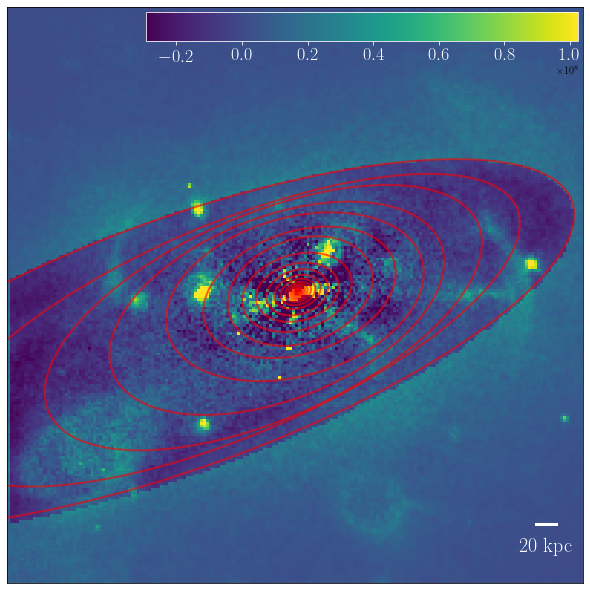

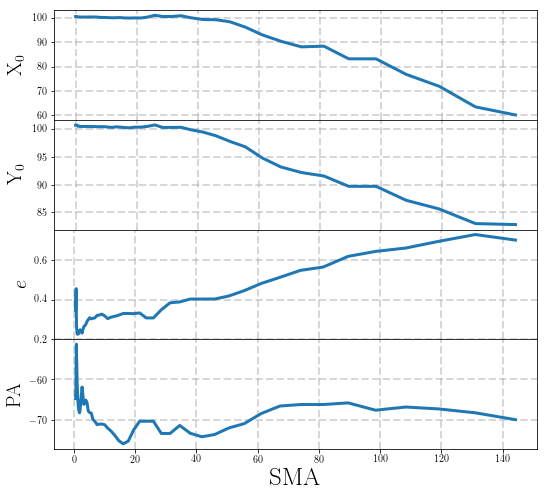

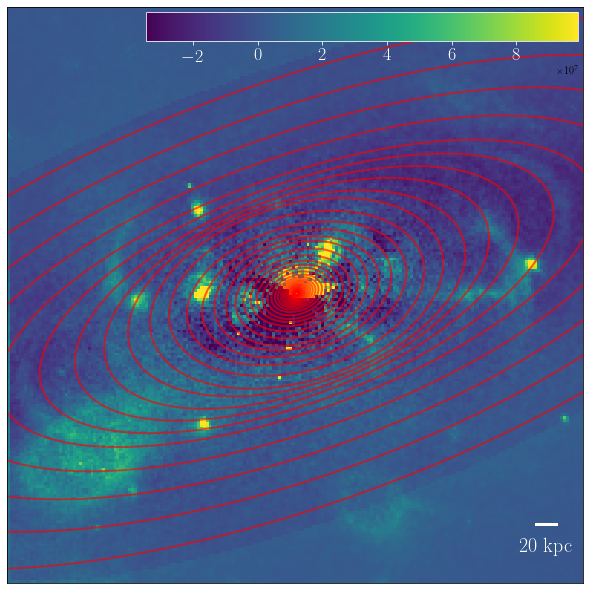

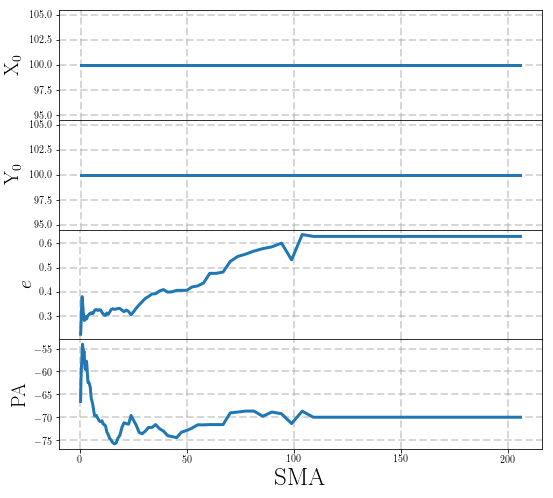

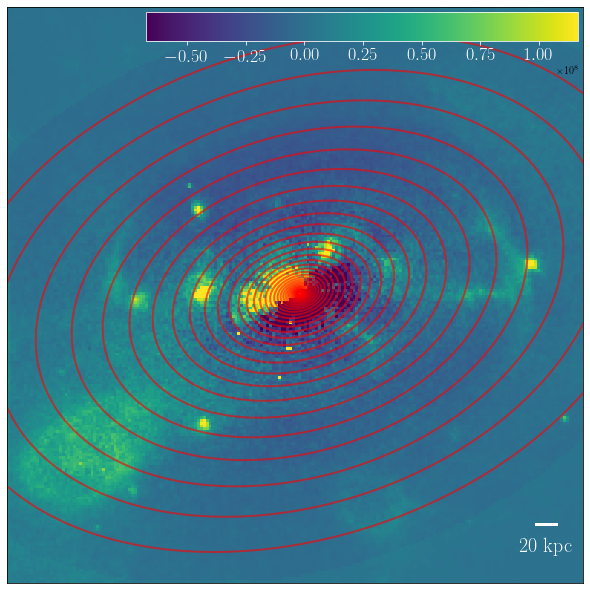

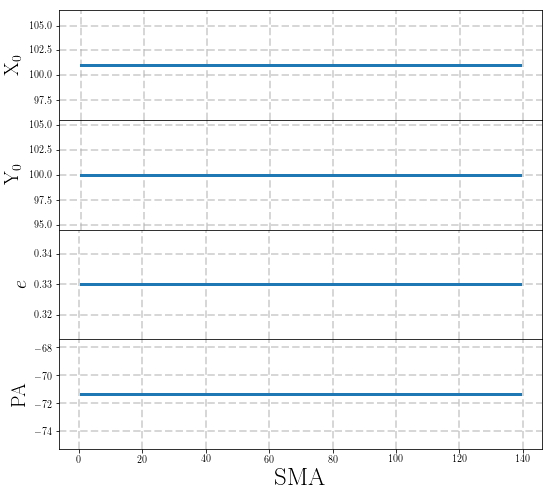

In [11]:
iso_cen, iso_cen_bin = fit_profile(illustris_file,3.0)
oneD_profile(iso_cen)

## Central + Satellites

Central+Satellites
# Mean Sky / RMS Sky = 17562028.00000 / 3435161.00000
# Detect 1 objects
****************STAGE 1****************
----------------------------------------------------------------------------------------------------
###      galX, galY :  99.9125543574 101.58151211
###      galR :  20.0
###      iniSma, maxSma :  10.0 150
###      Stage :  1
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : /Users/fardila/Documents/GitHub/HSC_vs_hydro/notebooks/felipe_test/maps/illustris_1_xy_cen_sat.fits
###

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in log10


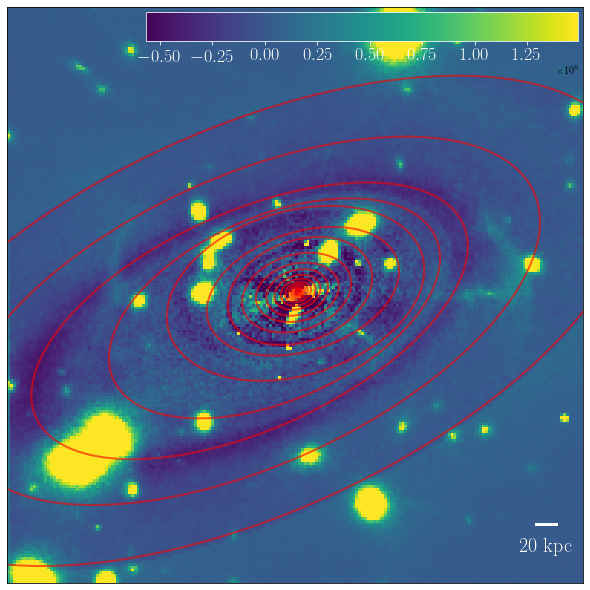

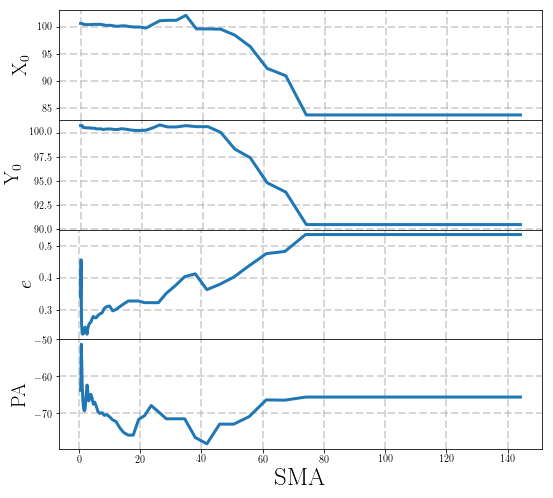

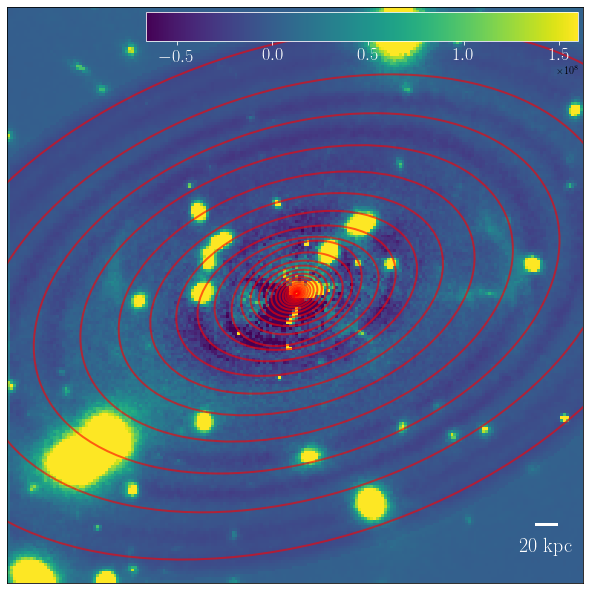

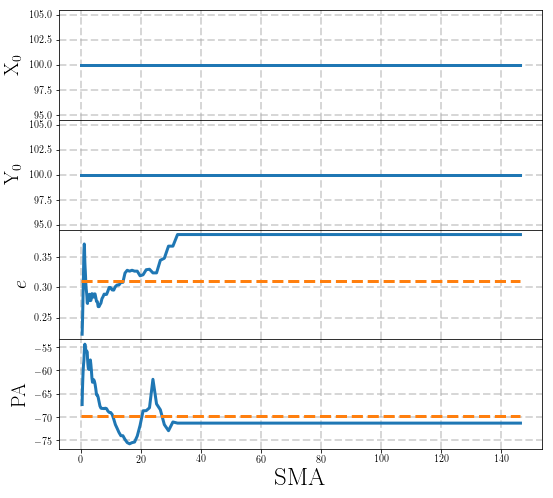

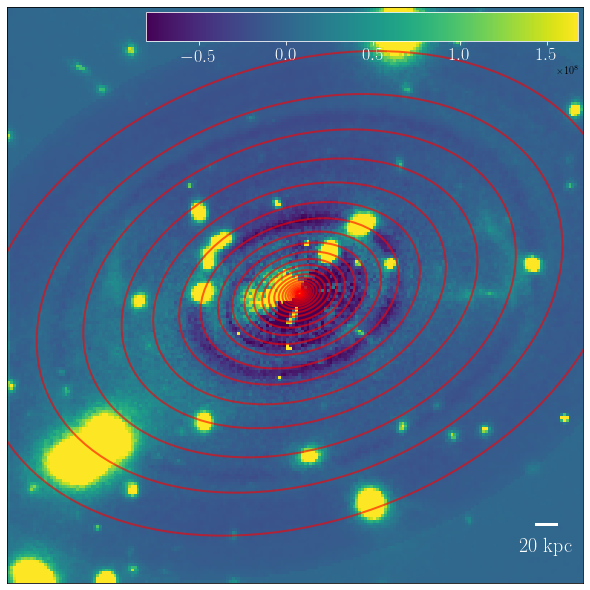

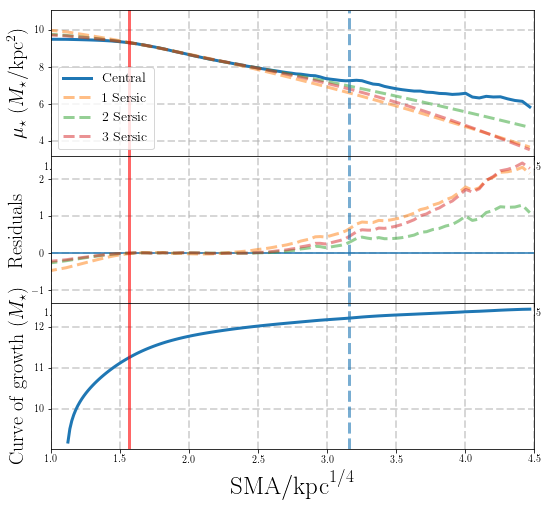

In [69]:
iso_cen_sat, iso_cen_sat_bin = fit_profile(illustris_file,3.0, sat=True)
oneD_profile(iso_cen_sat)

## compare profile with and without satellites

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


(1.0, 4.5)

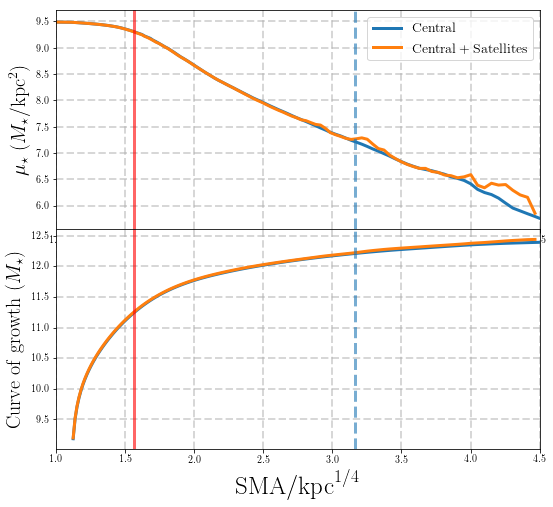

In [66]:
#Plot the 1-D mass density profile, the curve-of-growth of mass, and the residuals

# I label the 6.0 kpc (twice the pixel size, not resolved within) and 100 kpc radius
fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax1 = plt.subplot(2, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax1.plot((iso_cen['sma'] * 3.0) ** 0.25, 
         np.log10(iso_cen['intens'] / 9.0), linewidth=3.0,
         label=r'$\mathrm{Central}$')
ax1.plot((iso_cen_sat['sma'] * 3.0) ** 0.25, 
         np.log10(iso_cen_sat['intens'] / 9.0), linewidth=3.0,
         label=r'$\mathrm{Central + Satellites}$')
ax1.set_ylabel(r'$\mu_{\star}\ (M_{\star}/\mathrm{kpc}^2)$', fontsize=20)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.set_xlim(1.0, 4.5)
ax1.legend(fontsize=14)


ax2 = plt.subplot(2, 1, 2)
ax2.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax2.plot((iso_cen['sma'] * 3.0) ** 0.25, 
         np.log10(iso_cen['growth_ori']), linewidth=3.0)
ax2.plot((iso_cen_sat['sma'] * 3.0) ** 0.25, 
         np.log10(iso_cen_sat['growth_ori']), linewidth=3.0)
ax2.set_ylabel(r'$\mathrm{Curve\ of\ growth}\ (M_{\star})$', fontsize=20)
ax2.set_xlabel(r'$\mathrm{SMA/kpc}^{1/4}$', fontsize=25)
ax2.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax2.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax2.set_xlim(1.0, 4.5)


# Compare to HSC

In [12]:
hsc_data='/Users/fardila/Documents/Github/HSC_vs_hydro/Data/HSC/'
hscAvgProf0 = load_pkl(hsc_data+"hscAvgProf0.pkl")
hscAvgProf1 = load_pkl(hsc_data+"hscAvgProf1.pkl")
hscAvgProf2 = load_pkl(hsc_data+"hscAvgProf2.pkl")

rm0_sl, rm0_ml, rm0_aml = hscAvgProf0['all'], hscAvgProf0['med'], hscAvgProf0['avg']
rm1_sl, rm1_ml, rm1_aml = hscAvgProf1['all'], hscAvgProf1['med'], hscAvgProf1['avg']
rm2_sl, rm2_ml, rm2_aml = hscAvgProf2['all'], hscAvgProf2['med'], hscAvgProf2['avg']

# Universal RSMA array
RSMA_COMMON = np.arange(0.4, 4.2, 0.01)

# These are the median stellar mass density profiles for HSC galaxies at 0.3 < z < 0.5
# in three mass bins
# rm0 : 11.4 < logM_100kpc < 11.6 
# rm1 : 11.6 < logM_100kpc < 11.8 
# rm2 : 11.8 < logM_100kpc < 12.0 
# They are on a common radius array, and we use (r ** 0.25) as radius

1.0


(0.9, 4.5)

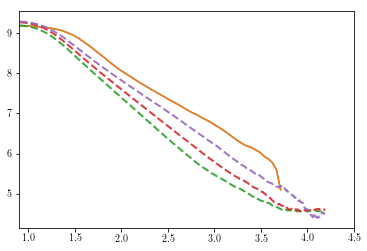

In [17]:
print(snap_a)
plt.plot((iso_cen['sma'] * 3.0 * h ) ** 0.25, 
         (iso_cen['sbp_cor'] / -2.5) + np.log10(0.7 ** 2.0))
plt.plot((iso_cen['sma'] * 3.0 * h * snap_a ) ** 0.25, 
         (iso_cen['sbp_cor'] / -2.5) + np.log10(0.7 ** 2.0))

## Median profiles from HSC
plt.plot(RSMA_COMMON, rm0_aml[2], linestyle='--', linewidth=2.0, 
         alpha=0.9, zorder=8)
plt.plot(RSMA_COMMON, rm1_aml[2], linestyle='--', linewidth=2.0, 
         alpha=0.9, zorder=8)
plt.plot(RSMA_COMMON, rm2_aml[2], linestyle='--', linewidth=2.0, 
         alpha=0.9, zorder=8)

plt.xlim(0.9, 4.5)

## plot for all 10 galaxies

In [ ]:
#save files for all 10 gals


Central only
# Mean Sky / RMS Sky = 720386.62500 / 269028.93750
# Detect 1 objects
****************STAGE 1****************
----------------------------------------------------------------------------------------------------
###      galX, galY :  99.5539313964 99.2446187605
###      galR :  20.0
###      iniSma, maxSma :  10.0 150
###      Stage :  1
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : /Users/fardila/Documents/GitHub/HSC_vs_hydro/notebooks/felipe_test/maps/illustris_1_xy_cen.fits
###      Input 

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log10


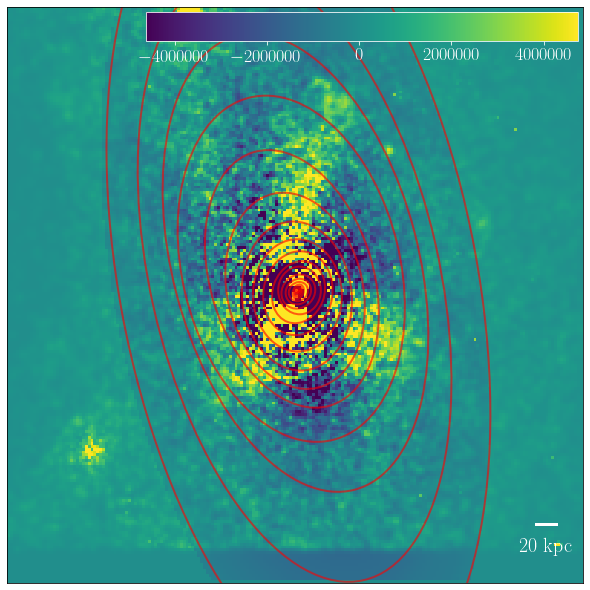

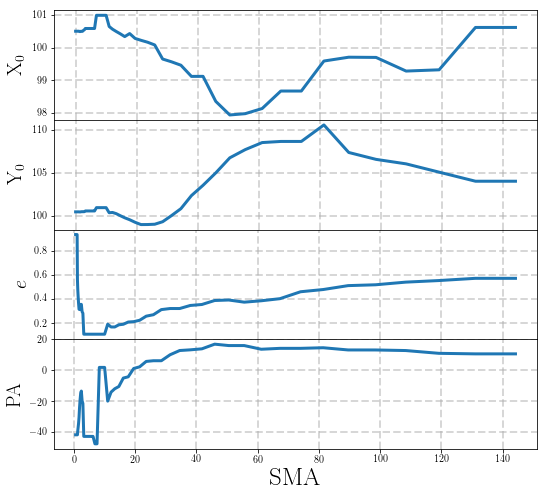

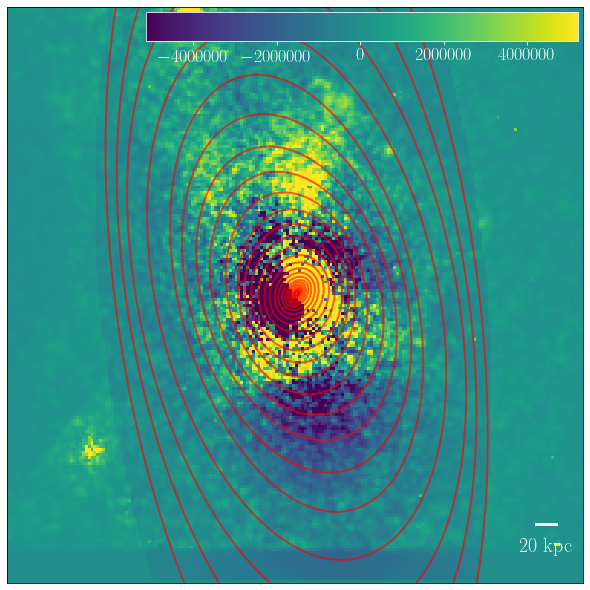

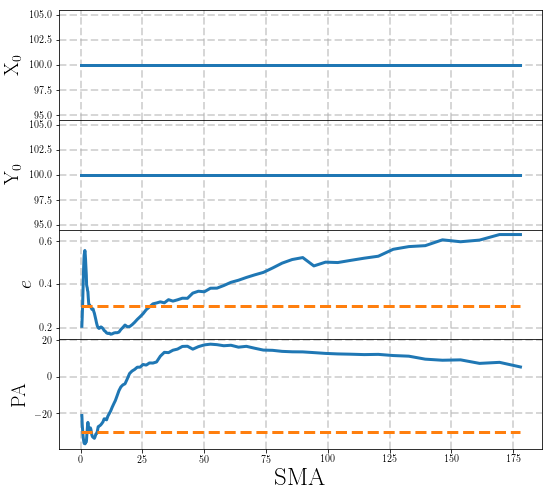

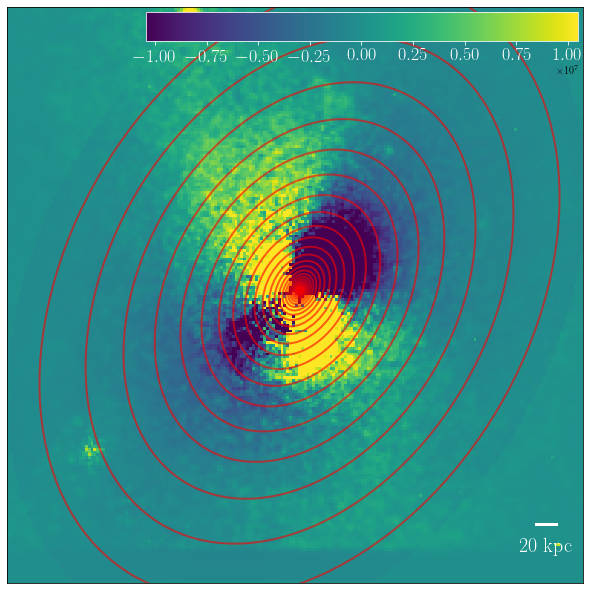

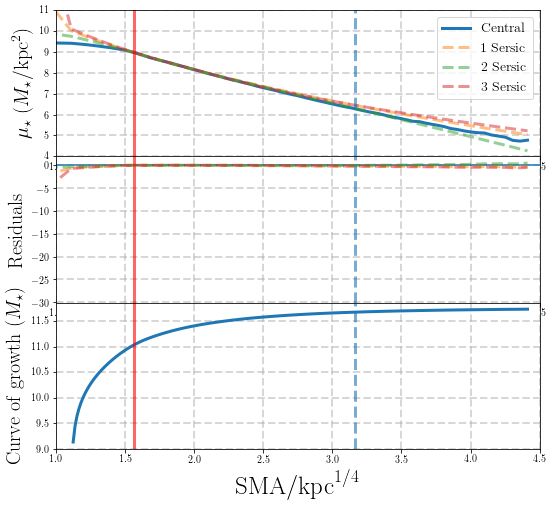

In [11]:
#galaxy2
#iso_2, iso_2_bin = fit_profile(illustris_file,pixel_scale=3.0,gal_n=1)
oneD_profile(iso_2)


In [1]:
#plot profile from files

In [25]:
isos=[]
#galaxy 5 causes script to freeze
for i in [0,1,2,3,4,6,7,8,9]:
    print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
    print('^^^^^^^^GALAXY '+str(i)+'^^^^^^^^^^^^^^')
    print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
    iso_cen, iso_cen_bin = fit_profile(illustris_file,pixel_scale=3.0,gal_n=i, plots=False)
    isos.append(iso_cen)

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 0^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Central only
# Mean Sky / RMS Sky = 15031176.00000 / 2641315.50000
# Detect 1 objects
****************STAGE 1****************
----------------------------------------------------------------------------------------------------
###      galX, galY :  99.5830640558 99.5123317515
###      galR :  20.0
###      iniSma, maxSma :  10.0 150
###      Stage :  1
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : /Users/fardila/

# Output file : /Users/fardila/Documents/GitHub/HSC_vs_hydro/notebooks/felipe_test/maps/illustris_1_xy_cen_ellip_2.bin
# Total stellar mass from the profile: logM = 11.7095
****************STAGE 3****************
----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  50.0 250
###      Stage :  3
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : /Users/fardila/Documents/GitHub/HSC_

----------------------------------------------------------------------------------------------------


/Users/fardila/Documents/Github/kungpao/kungpao/galsbp/galSBP.py:577: RuntimeWarning: divide by zero encountered in log10
  sbpOri = zp - 2.5 * np.log10(intensOri / (pixArea * exptime))
/Users/fardila/Documents/Github/kungpao/kungpao/galsbp/galSBP.py:578: RuntimeWarning: divide by zero encountered in log10
  sbpSub = zp - 2.5 * np.log10(intensSub / (pixArea * exptime))
/Users/fardila/Documents/Github/kungpao/kungpao/galsbp/galSBP.py:588: RuntimeWarning: divide by zero encountered in log10
  (pixArea * exptime))
/Users/fardila/Documents/Github/kungpao/kungpao/galsbp/galSBP.py:589: RuntimeWarning: invalid value encountered in subtract
  sbp_err = (sbpSub - sbp_low)
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean,

----------------------------------------------------------------------------------------------------
###     Input background value   :  0.0
###     1-D SBP background value :  0.0
###     Current outer background :  0.0
----------------------------------------------------------------------------------------------------
# Output file : /Users/fardila/Documents/GitHub/HSC_vs_hydro/notebooks/felipe_test/maps/illustris_1_xy_cen_ellip_1.bin
# Total stellar mass from the profile: logM = 11.6506
****************STAGE 2****************
----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  10.0 220
###      Stage :  2
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
--------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
###     Input background value   :  0.0
###     1-D SBP background value :  17605.17
###     Current outer background :  17605.17
----------------------------------------------------------------------------------------------------
# Output file : /Users/fardila/Documents/GitHub/HSC_vs_hydro/notebooks/felipe_test/maps/illustris_1_xy_cen_ellip_3.bin
# Total stellar mass from the profile: logM = 11.4819
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 6^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Central only
# Mean Sky / RMS Sky = 21197.19141 / 29666.56445
# Detect 1 objects
****************STAGE 1****************
----------------------------------------------------------------------------------------------------
###      galX, galY :  99.4544644537 99.5316481892
###      galR :  20.0
###   

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
###     Input background value   :  0.0
###     1-D SBP background value :  0.0007339264
###     Current outer background :  0.0007339264
----------------------------------------------------------------------------------------------------
# Output file : /Users/fardila/Documents/GitHub/HSC_vs_hydro/notebooks/felipe_test/maps/illustris_1_xy_cen_ellip_2.bin
# Total stellar mass from the profile: logM = 11.2153
****************STAGE 3****************
----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  50.0 250
###      Stage :  3
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
###     Input background value   :  0.0
###     1-D SBP background value :  0.0
###     Current outer background :  0.0
----------------------------------------------------------------------------------------------------
# Output file : /Users/fardila/Documents/GitHub/HSC_vs_hydro/notebooks/felipe_test/maps/illustris_1_xy_cen_ellip_1.bin
# Total stellar mass from the profile: logM = 11.3089
****************STAGE 2****************
----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  10.0 220
###      Stage :  2
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse

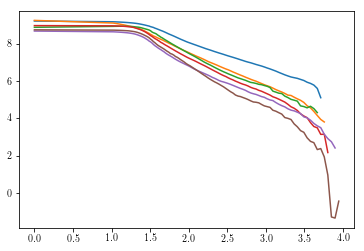

In [45]:
plt.plot((isos[0]['sma'] * 3.0*h) ** 0.25, (isos[0]['sbp_cor'] / -2.5) + np.log10(0.7 ** 2.0), label='0')
plt.plot((isos[1]['sma'] * 3.0*h) ** 0.25, (isos[1]['sbp_cor'] / -2.5) + np.log10(0.7 ** 2.0), label='1')
plt.plot((isos[2]['sma'] * 3.0*h) ** 0.25, (isos[2]['sbp_cor'] / -2.5) + np.log10(0.7 ** 2.0), label='2')
#plt.plot((isos[3]['sma'] * 3.0*h) ** 0.25, (isos[3]['sbp_cor'] / -2.5) + np.log10(0.7 ** 2.0), label='3')
plt.plot((isos[4]['sma'] * 3.0*h) ** 0.25, (isos[4]['sbp_cor'] / -2.5) + np.log10(0.7 ** 2.0), label='4')
plt.plot((isos[5]['sma'] * 3.0*h) ** 0.25, (isos[5]['sbp_cor'] / -2.5) + np.log10(0.7 ** 2.0), label='5')
plt.plot((isos[6]['sma'] * 3.0*h) ** 0.25, (isos[6]['sbp_cor'] / -2.5) + np.log10(0.7 ** 2.0), label='6')
#plt.plot((isos[7]['sma'] * 3.0*h) ** 0.25, (isos[7]['sbp_cor'] / -2.5) + np.log10(0.7 ** 2.0), label='7')
#plt.plot((isos[8]['sma'] * 3.0*h) ** 0.25, (isos[8]['sbp_cor'] / -2.5) + np.log10(0.7 ** 2.0), label='8')
#plt.legend()

In [35]:
#plot isos
print(len(isos))
for i in range(len(isos)):
    print(i)
    plt.plot((isos[i]['sma'] * 3.0*h) ** 0.25, (isos[i]['sbp_cor'] / -2.5) + np.log10(0.7 ** 2.0))
    
#plt.show()    

9
0
1
2
3
4
5
6
7
8


TimeoutError: LOCKERROR: matplotlib is trying to acquire the lock
    u'/Users/fardila/.matplotlib/tex.cache/.matplotlib_lock-*'
and has failed.  This maybe due to any other process holding this
lock.  If you are sure no other matplotlib process is running try
removing these folders and trying again.


# Detect 36 objects


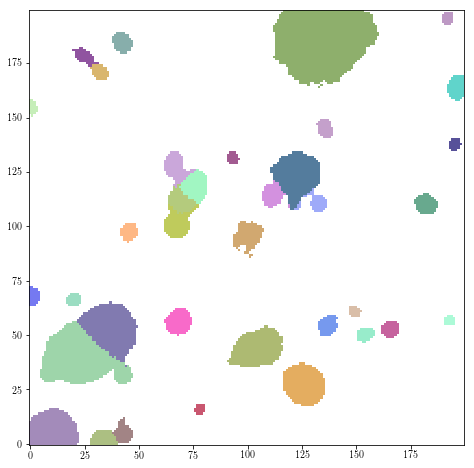

In [77]:
# Load general simulation and galaxy properties
f = h5py.File(illustris_file, 'r')
snap_a = f.attrs['snap_a']
n_galaxies = len(f['cat_sh_id'])
sh_idx = np.array(f['cat_sh_id'])
grp_idx = np.array(f['cat_grp_id'])
cat_is_primary = np.array(f['cat_grp_is_primary'])
cat_sh_mstar = np.array(f['cat_sh_mstar'])
cat_sh_pos_bound = np.array(f['cat_sh_pos_bound'])
cat_sh_halfmrad_stars = np.array(f['cat_sh_halfmrad_stars'])

map_stars = np.array(f['map_stars'])
map_size = f['map_stars_size'].value
n_pixels = f['map_stars_npixel'].value
f.close()

#make maps
img_cen = map_stars[0, 0, 1] * (pixel_scale ** 2) # Central 
img_sat = map_stars[0, 1, 1] * (pixel_scale ** 2) # Satellites
img_icl = map_stars[0, 2, 1] * (pixel_scale ** 2) # Diffuse
img_cen_sat = (img_cen + img_sat)           # Central + Satellites
img_cen_icl = (img_cen + img_icl)           # Central + Satellites
img_all = (img_cen + img_sat + img_icl)           # Central + Satellites + Diffuse

bkg = sep.Background(img_cen, bw=10, bh=10, fw=5, fh=5)

objs_sat, seg_sat = sep.extract(img_sat, 2.0,
                                err=bkg.globalrms,
                                minarea=20, 
                                deblend_nthresh=48, deblend_cont=0.01,
                                segmentation_map=True)

seg_mask = (seg_sat > 0)
print("# Detect %d objects" % len(objs_sat))

plt.figure(figsize=(8, 8))
plt.imshow(seg_sat, origin='lower', cmap=SEG_CMAP, 
           alpha=0.9)

In [10]:
print(iso_cen)

   sma        intens      int_err    ...  mag_tot_ori    mag_tot_sub  
--------- ------------- ------------ ... -------------- --------------
      0.0 30084870000.0          nan ... -30.8078367285 -30.8078367285
0.5095395 27477090000.0  799643648.0 ... -30.8078367285 -30.8078367285
0.5350164 27347050000.0  837536704.0 ... -30.8078367285 -30.8078367285
0.5617672 27210510000.0  877119552.0 ... -30.8078367285 -30.8078367285
0.5898556 27067200000.0  918450624.0 ... -30.8078367285 -30.8078367285
0.6193483 26916760000.0  961588544.0 ... -30.8078367285 -30.8078367285
0.6503156 26758840000.0 1006609000.0 ... -30.8078367285 -30.8078367285
0.6828314 26593090000.0 1053568000.0 ... -30.8078367285 -30.8078367285
0.7169729 26419100000.0 1102541000.0 ... -30.8078367285 -30.8078367285
0.7528216 26236470000.0 1153589000.0 ... -30.8078367285 -30.8078367285
      ...           ...          ... ...            ...            ...
 85.51692    23247094.0    1312593.0 ... -30.8078367285 -30.8078367285
 89.79

In [84]:
map_stars[1]

array([[[[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
         ..., 
         [  1.11769756e+04,   1.61200830e+04,   1.63267451e+04, ...,
            1.48928088e+03,   1.81635730e+03,   3.09065747e+03],
         [  1.30721123e+04,   1.79695742e+04,   1.57574121e+04, ...,
            3.19451025e+03,   1.25280066e+03,   9.16735596e+02],
         [  1.43776885e+04,   1.83320312e+04,   1.48383555e+04, ...,
            5.21632471e+03,   1.71257288e+03,   1.07317090e+03]],

        [[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00,